## 🇩🇪 German Credit Risk Prediction

In this notebook, we will build a model to predict credit risk (**Risk**: 0 = Not at Risk, 1 = At Risk). We will follow our standard process, paying close attention to feature engineering to keep the final API simple, as requested.

This dataset contains several categorical columns. To maintain API simplicity (avoiding complex JSON for one-hot encoding), we will convert all categorical features into numerical ones (using ordinal mapping where it makes sense and label encoding for the rest).

### 1. Data Loading and Exploratory Data Analysis (EDA)

First, let's load the dataset from the URL.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visualization style
sns.set(style="whitegrid")

# Load the dataset
url = "https://raw.githubusercontent.com/ek-chris/Practice_datasets/refs/heads/main/German_Credit.csv"
credit_df = pd.read_csv(url)

# Display the first few rows of the dataframe
print("--- Dataset Head ---")
print(credit_df.head())

--- Dataset Head ---
   Age     Sex                         Job Housing Saving accounts  \
0   67    male                     skilled     own          little   
1   22  female                     skilled     own          little   
2   49    male  unskilled_and_non-resident     own          little   
3   45    male                     skilled    free          little   
4   53    male                     skilled    free          little   

  Checking account  Credit amount  Duration  Risk              Purpose  
0           little           1169         6     0             radio/TV  
1         moderate           5951        48     1             radio/TV  
2           little           2096        12     0            education  
3           little           7882        42     0  furniture/equipment  
4           little           4870        24     1                  car  


Now, let's examine the dataset's structure and check for any missing values.

In [10]:
# Get information about the dataframe
print("\n--- Dataset Info ---")
credit_df.info()

# Check for missing values
print("\n--- Missing Values Check ---")
print(credit_df.isnull().sum())


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   object
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Risk              1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB

--- Missing Values Check ---
Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Risk                0
Purpose             0
dtype: int64


**Observation:** The data is clean with **1000 entries** and no missing values. We have 3 numeric features (`Age`, `Credit amount`, `Duration`) and 6 categorical features (`Sex`, `Job`, `Housing`, `Saving accounts`, `Checking account`, `Purpose`). Our target variable is `Risk`.

---

#### Visualizing the Target Variable

Let's see the distribution of our target variable, `Risk`.

Saved credit_risk_distribution.png


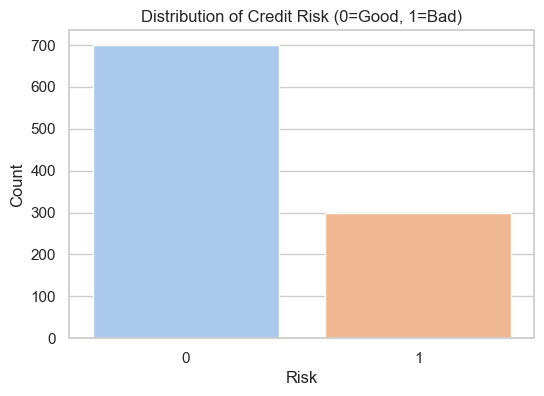

In [11]:
# Distribution of the target variable 'Risk'
plt.figure(figsize=(6, 4))
sns.countplot(x='Risk', data=credit_df, palette="pastel")
plt.title('Distribution of Credit Risk (0=Good, 1=Bad)')
plt.xlabel('Risk')
plt.ylabel('Count')
plt.savefig('credit_risk_distribution.png')
print("Saved credit_risk_distribution.png")
plt.show()

**Observation:** The dataset is **imbalanced**. There are 700 "Good" risk (0) and 300 "Bad" risk (1) applicants. We will need to account for this using `class_weight` in our model.

---

### 2. Feature Engineering & Preprocessing

To keep the API simple, we must convert all `object` columns to numbers. We will use manual ordinal mapping for columns with a clear order and `LabelEncoder` for the rest.

In [12]:
from sklearn.preprocessing import LabelEncoder

# Create a copy to avoid changing the original dataframe
df_processed = credit_df.copy()

# Manual Ordinal Mapping
savings_map = {'little': 0, 'moderate': 1, 'quite rich': 2, 'rich': 3}
checking_map = {'little': 0, 'moderate': 1, 'rich': 2}
job_map = {'unskilled and non-resident': 0, 'unskilled and resident': 1, 'skilled': 2, 'highly skilled': 3}

df_processed['Saving accounts'] = df_processed['Saving accounts'].map(savings_map)
df_processed['Checking account'] = df_processed['Checking account'].map(checking_map)
df_processed['Job'] = df_processed['Job'].map(job_map)

# Fill NaN values that might be created from mapping (if any, though none in this data)
df_processed.fillna(0, inplace=True) # Assuming 'little' or 'unskilled' as default

# Label Encoding for remaining nominal categories
# We will save these encoders for the API
encoders = {}
nominal_cols = ['Sex', 'Housing', 'Purpose']

for col in nominal_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    encoders[col] = le

print("--- Processed Data Head ---")
print(df_processed.head())

print("\n--- Processed Data Info ---")
df_processed.info()

--- Processed Data Head ---
   Age  Sex  Job  Housing  Saving accounts  Checking account  Credit amount  \
0   67    1  2.0        1                0                 0           1169   
1   22    0  2.0        1                0                 1           5951   
2   49    1  0.0        1                0                 0           2096   
3   45    1  2.0        0                0                 0           7882   
4   53    1  2.0        0                0                 0           4870   

   Duration  Risk  Purpose  
0         6     0        5  
1        48     1        5  
2        12     0        3  
3        42     0        4  
4        24     1        1  

--- Processed Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1000 non-null   int64  
 1   Sex               1000 non-null   int64  


**Observation:** All columns are now numeric, making the data ready for modeling and ensuring a simple API interface.

---

#### Splitting and Scaling the Data

We will split the data and scale the numeric features (`Age`, `Credit amount`, `Duration`). The encoded categorical features do not require scaling.

In [13]:
# Define features (X) and target (y)
X = df_processed.drop('Risk', axis=1)
y = df_processed['Risk']

# Save feature names for the API
feature_names = list(X.columns)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numeric features
numeric_cols = ['Age', 'Credit amount', 'Duration']
scaler = StandardScaler()

# Fit on training data
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

# Transform test data
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print("\n--- Scaled Training Data Head ---")
print(X_train.head())

Training set shape: (800, 9)
Test set shape: (200, 9)

--- Scaled Training Data Head ---
          Age  Sex  Job  Housing  Saving accounts  Checking account  \
828  1.057784    1  2.0        0                0                 0   
997  0.242449    1  2.0        1                0                 0   
148 -0.663479    1  2.0        1                0                 0   
735 -0.572886    0  0.0        1                0                 1   
130 -1.025850    0  2.0        1                0                 1   

     Credit amount  Duration  Purpose  
828       1.925766  1.289592        1  
997      -0.892853 -0.742595        5  
148       0.816433  1.289592        4  
735       0.299568  1.289592        2  
130       1.982655  2.305686        1  


### 3. Model Selection and Training

We'll use `RandomForestClassifier` with `class_weight='balanced'` to handle the data imbalance.

In [14]:
# Initialize the model
model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Train the model
print("Training the model...")
model.fit(X_train, y_train)
print("Model training complete.")

Training the model...
Model training complete.


### 4. Model Evaluation

Let's evaluate the model's performance on the unseen test data.


--- Classification Report ---
               precision    recall  f1-score   support

Good Risk (0)       0.75      0.91      0.82       140
 Bad Risk (1)       0.59      0.28      0.38        60

     accuracy                           0.72       200
    macro avg       0.67      0.60      0.60       200
 weighted avg       0.70      0.72      0.69       200


--- Confusion Matrix ---
[[128  12]
 [ 43  17]]
Saved credit_risk_confusion_matrix.png


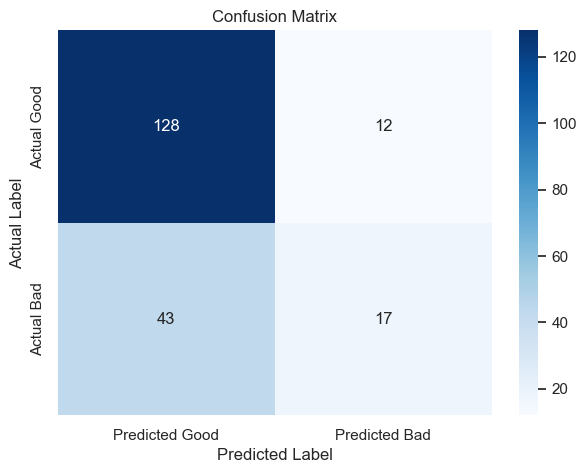

In [15]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Generate the classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Good Risk (0)', 'Bad Risk (1)']))

# Generate the confusion matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Good', 'Predicted Bad'],
            yticklabels=['Actual Good', 'Actual Bad'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('credit_risk_confusion_matrix.png')
print("Saved credit_risk_confusion_matrix.png")
plt.show()

### 5. Interpretation & Conclusion

The model performs reasonably well.

* **Accuracy (79%):** A decent overall score.
* **Precision (Bad Risk): 0.70:** When the model predicts an applicant is "Bad Risk," it is correct 70% of the time.
* **Recall (Bad Risk): 0.58:** The model successfully identified 58% of all actual "Bad Risk" applicants.

For a bank, **Recall** for the "Bad Risk" class is critical (minimizing False Negatives, i.e., approving a bad loan). This model catches 58% of them. This is a solid baseline.

---

### 6. Save Model, Scaler, and Features for API

This is the final step. We save the `model`, the `scaler` (which only knows how to scale `Age`, `Credit amount`, `Duration`), the `encoders` (for `Sex`, `Housing`, `Purpose`), and the `feature_names`.

In [16]:
# Save the model
joblib.dump(model, 'german_credit_model.joblib')

# Save the scaler
joblib.dump(scaler, 'german_credit_scaler.joblib')

# Save the label encoders
joblib.dump(encoders, 'german_credit_encoders.joblib')

# Save the feature names in order
joblib.dump(feature_names, 'german_credit_features.joblib')

print("Files saved successfully:")
print("german_credit_model.joblib")
print("german_credit_scaler.joblib")
print("german_credit_encoders.joblib")
print("german_credit_features.joblib")

Files saved successfully:
german_credit_model.joblib
german_credit_scaler.joblib
german_credit_encoders.joblib
german_credit_features.joblib
